# RARL for Fire Search and Rescue

## Imports

In [ ]:
!sudo apt-get update
!sudo apt-get install -y xvfb ffmpeg freeglut3-dev
!pip install 'imageio==2.4.0'
!pip install pyvirtualdisplay
!pip install tf-agents[reverb]
!pip install pyglet
!pip install mdptoolbox.example

Get:1 https://cloud.r-project.org/bin/linux/ubuntu focal-cran40/ InRelease [3,622 B]
Hit:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2004/x86_64  InRelease
Hit:3 http://archive.ubuntu.com/ubuntu focal InRelease
Get:4 http://security.ubuntu.com/ubuntu focal-security InRelease [114 kB]
Get:5 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu focal InRelease [18.1 kB]
Get:6 http://archive.ubuntu.com/ubuntu focal-updates InRelease [114 kB]
Hit:7 http://ppa.launchpad.net/cran/libgit2/ubuntu focal InRelease
Get:8 http://security.ubuntu.com/ubuntu focal-security/universe amd64 Packages [1,047 kB]
Hit:9 http://ppa.launchpad.net/deadsnakes/ppa/ubuntu focal InRelease
Get:10 http://archive.ubuntu.com/ubuntu focal-backports InRelease [108 kB]
Get:11 http://archive.ubuntu.com/ubuntu focal-updates/main amd64 Packages [3,169 kB]
Get:12 http://ppa.launchpad.net/graphics-drivers/ppa/ubuntu focal InRelease [24.3 kB]
Get:13 http://security.ubuntu.com/ubuntu focal-security/main amd6

In [ ]:
from IPython.utils.sysinfo import encoding
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image

import tensorflow as tf
import numpy as np
import copy

from tf_agents.environments import py_environment
from tf_agents.environments import tf_environment
from tf_agents.environments import tf_py_environment
from tf_agents.environments import utils
from tf_agents.specs import array_spec
from tf_agents.environments import wrappers
from tf_agents.environments import suite_gym
from tf_agents.trajectories import time_step as ts
from tensorflow.python.ops.linalg_ops import batch_matrix_solve_eager_fallback

from __future__ import absolute_import, division, print_function

import base64
import imageio
import IPython
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import PIL.Image
import pyvirtualdisplay
import reverb

import tensorflow as tf

from tf_agents.agents.dqn import dqn_agent
from tf_agents.drivers import py_driver
from tf_agents.environments import suite_gym
from tf_agents.environments import tf_py_environment
from tf_agents.eval import metric_utils
from tf_agents.metrics import tf_metrics
from tf_agents.networks import sequential
from tf_agents.policies import py_tf_eager_policy
from tf_agents.policies import random_tf_policy
from tf_agents.replay_buffers import reverb_replay_buffer
from tf_agents.replay_buffers import reverb_utils
from tf_agents.trajectories import trajectory
from tf_agents.specs import tensor_spec
from tf_agents.utils import common

import gym
import numpy as np
import time, pickle, os
import random
import matplotlib.pyplot as plt

tf.compat.v1.enable_v2_behavior()

RuntimeError: ignored

In [ ]:
# Install openmesh
# !pip install openmesh

# Visualization libraries
import tqdm
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import animation, rc

%matplotlib inline
%config InlineBackend.figure_format='retina'

import numpy as np
import torch

# To make code more readable: some helpful Python 3 type hints
from typing import Callable, List, Optional, Tuple, Any, Iterable

# We'll use a namedtuple to store scene information in an accessible way
from collections import namedtuple

In [ ]:
%matplotlib inline
import numpy as np
from numpy.fft import fft2, ifft2, fftshift, ifftshift
from numpy import angle, real
from numpy import exp, abs, pi, sqrt
import matplotlib.pyplot as plt
import cv2
import scipy.ndimage as ndimage
from scipy.signal import convolve2d

def imshow(im, cmap='gray'):
    # clip image from 0-1
    im = np.clip(im, 0, 1)
    plt.imshow(im, cmap=cmap)

# CHANGE THESE FOR YOUR LOCAL PATHS

In [ ]:
from google.colab import drive

# CHANGE THESE PATH VARIABLES
drive.mount('/content/drive')
map='/content/drive/MyDrive/forest_env.png'
color_reduced_map='/content/drive/MyDrive/color_reduced_image.PNG'
#map='/content/cognitive_robotics_img.PNG'
#color_reduced_map='/content/cognitive_robotics_img.PNG'

# Environment Building

In [ ]:
def img2arr(img):
  arr = cv2.imread(img)
  return arr

def arr2img(arr, figuresize):
  # Smaller (downsampled) image
  plt.figure(figsize=figuresize) # for downsampling
  plt.imshow(cv2.cvtColor(arr, cv2.COLOR_BGR2RGB))
  plt.show()


In [ ]:
# https://onlinejpgtools.com/reduce-jpg-colors
# color reducer
color_reduced_map='/content/cognitive_robotics_img.PNG'
color_reduced_map='/content/drive/MyDrive/color_reduced_image.PNG'

color_reduced_arr = img2arr(color_reduced_map)
h,w,_ = color_reduced_arr.shape
resized = cv2.resize(color_reduced_arr, (75, 75), interpolation = cv2.INTER_AREA)
thresh = np.where(resized > (np.max(resized)+np.min(resized))/2, 255, 0)
img_float32 = np.float32(thresh)
arr2img(img_float32, (5,5))

In [ ]:
# start with full observability

class ForestFireEnvironment(py_environment.PyEnvironment):
  def __init__(self, board_configuration=None, fire_seed=None, drone_location=None, person_location=None):
    # initialize moves
    # have board to reset to (init board)
    # have current board
    # have target location
    # have curent location
    # have fire position

    # moves
    self._action_spec = array_spec.BoundedArraySpec(
            shape=(), dtype=np.int32, minimum=0, maximum=5000, name="action")
    self.moves = {0:(0,-1), 1:(0,1), 2:(-1,0), 3:(1,0)}
    # board
    self.height = board_configuration.shape[0]
    self.width = board_configuration.shape[1]
    self.board = np.array(copy.deepcopy(board_configuration)).flatten() # STAYS THE SAME
    self.init_board = np.array(copy.deepcopy(board_configuration)).flatten()
    # drone location
    self._init_drone = self.__coord2idx(drone_location)
    # person location
    self._init_person = self.__coord2idx(person_location) # STAYS THE SAME
    # fire location
    self._init_fire = self.__coord2idx(fire_seed)
    self.board[self._init_fire] = 3
    self.init_board[self._init_fire] = 3
    # states
    self._state = np.concatenate((self.board, np.array([self._init_drone]), np.array([self._init_person])))
    self._init_state = np.concatenate((self.init_board, np.array([self._init_drone]), np.array([self._init_person])))
    # other
    self._episode_ended = False
    self.count = 0

  def __idx2coord(self, idx):
    # idx: integer
    return (idx%self.width, idx//self.width)

  def __coord2idx(self, coords):
    # coords: tuple
    return coords[0] + coords[1]*self.width

  def _reset(self):
    print('RESET')
    print(self._state[-3:])
    self.count = 0
    self._state = np.copy(self._init_state)
    self._episode_ended = False
    print(self._state[-3:])
    return ts.restart(np.array(self._state, dtype=np.int32))

  def __spread_fire(self, fire_locations):
    # fire_locations: set of coords

    # find adjacent locations
    # threshold for spreading
    # update fire locations
    thresh = 0.9
    directions = [(0,1),(0,-1),(1,0),(-1,0)]
    new_fire_locations = fire_locations.copy()
    neighbors = set()
    for loc in fire_locations:
      for dir in directions:
        new_loc = (loc[0]+dir[0],loc[1]+dir[1])
        if self.__in_bounds(new_loc) and (new_loc not in fire_locations) and (new_loc not in neighbors):
          neighbors.add(new_loc)
    for neighbor in neighbors:
      val = random.random()
      if val > thresh:
        new_fire_locations.add(neighbor)
    # return coordinates
    return new_fire_locations

  def __in_bounds(self, coord):
    # coord: tuple
    if coord[0] >= 0 and coord[1] >= 0 and coord[1] < self.height and coord[0] < self.width:
      return True
    return False

  def __can_move(self, drone, action, fire):
    # drone: tuple
    # action: tuple
    # fire: set or tuples
    new_loc = (drone[0]+action[0], drone[1]+action[1])
    if self.__in_bounds(new_loc) and new_loc not in fire:
      return True
    return False

  def __compress_board(self, fire, drone):
    # fire: set of integers
    # drone: integer

    # copy init board, no fire no person
    new_board = np.copy(self.init_board)
    # add fire
    for pos in fire:
      posidx = self.__coord2idx(pos)
      new_board[posidx] = 3
    droneidx = self.__coord2idx(drone)
    new_board = np.concatenate((new_board, np.array([droneidx]), np.array([self._init_person])))
    return new_board

  def __extract_board(self):
    # USING FLATTENDED BOARD WITH STUFF AT END
    # get fire
    # get person
    fire_locations = set()
    for i, pos in enumerate(self._state):
      if pos == 3 and i < self.width*self.height: # fire
        fire_locations.add(i)
    drone_location = self._state[-2] 
    # returns indicies
    return fire_locations, drone_location
    
  def _step(self, action):
    action = self.moves[action]
    fire, drone = self.__extract_board()
    fire = {self.__idx2coord(idx) for idx in fire}
    drone = self.__idx2coord(drone)
    self.count += 1
    if self._episode_ended: # if goal reached
        return self.reset()
    if self.count >= 10000:
      self._episode_ended = True
      return ts.termination(np.array(self._state, dtype=np.int32), reward=0)
    elif self.__can_move(drone, action, fire): # if a valid move
      new_loc = (drone[0]+action[0], drone[1]+action[1])
      if new_loc == self._init_person: # found goal
        self._episode_ended = True
        return ts.termination(np.array(self._state, dtype=np.int32), reward=100)
      else: # moved
        drone = new_loc
        fire = self.__spread_fire(fire)
        self._state = self.__compress_board(fire, drone)
        return ts.transition(np.array(self._state, dtype=np.int32), reward=-1)
    else:
      self._episode_ended = True
      return ts.termination(np.array(self._state, dtype=np.int32), reward=-100)

  def _current_time_step(self):
    return self.current_time_step()

  def getBoard(self):
    return self.board

  def action_spec(self):
    return self._action_spec # 0,1,2,3 correspond to directions in moves

  def observation_spec(self):
    return self._observation_spec

In [ ]:
map = (img_float32[:,:,0] > 5).astype(int)
test_map = map[:15,:15]
fire_seed = (1,1)
drone_location = (5,5)
person_location = (13,13)
env = ForestFireEnvironment(board_configuration=test_map, fire_seed=fire_seed, drone_location=drone_location, person_location=person_location)

In [ ]:
env._state
obervation_first = env._step(2).observation
env._ForestFireEnvironment__extract_board()[0]
env._step(3)

TimeStep(
{'discount': array(1., dtype=float32),
 'observation': array([  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   3,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,

In [ ]:
def redo_board(observation):
  # 0 = black (0,0,0)
  # 1 = white (255,255,255)
  # 3 = fire = red (255,0,0)
  # drone = blue (0,0,255)
  # person = green (0,255,0)
  colors = {0:np.array([0,0,0]), 1:np.array([225,225,225]), 3:np.array([255,0,0])}
  board_size = len(observation)-2
  image = np.zeros((board_size, 3))
  for i in range(board_size):
    image[i,:] = colors[observation[i]]
  image[observation[-2],:] = np.array([0,0,255])
  image[observation[-1],:] = np.array([0,225,0])

  image = image.reshape(int(board_size**0.5), int(board_size**0.5), 3)
  return image
  #ax.imshow(image)
  axis_image = ax.imshow(image)
  return axis_image

In [ ]:
def show_board(observation, ax=plt, frames_changed=True):
  # 0 = black (0,0,0)
  # 1 = white (255,255,255)
  # 3 = fire = red (255,0,0)
  # drone = blue (0,0,255)
  # person = green (0,255,0)
  image = observation
  if frames_changed == False:
    image = redo_board(observation)
  axis_image = ax.imshow(image)
  return axis_image

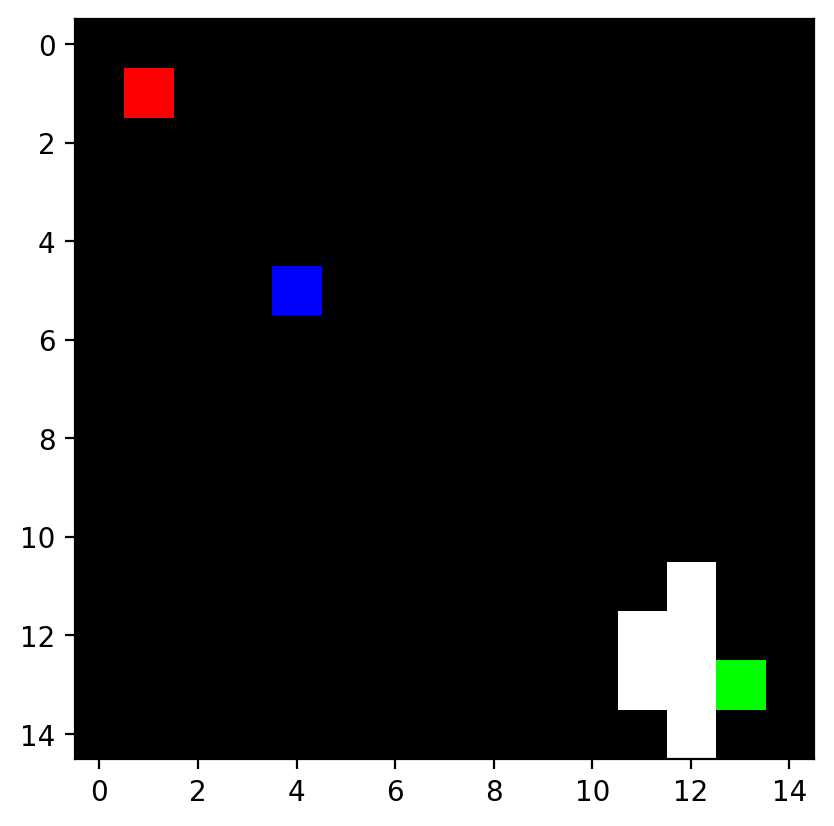

In [ ]:
show_board(obervation_first, frames_changed=False)

In [ ]:
# Animation wrapper to make it easy to display a series of frames in colab
class AnimationWrapper():
    def __init__(self, rows, cols, frames, figsize=(8, 6)):
        self.rows, self.cols = rows, cols
        self.frames = frames
        for i in range(len(frames)):
          self.frames[i][0] = redo_board(frames[i][0])
          
        
        self.fig = plt.figure(figsize=figsize)
        self.axes = []
        self.axis_images = []
        self.data = []
        self.pbar = None
        for r in range(rows):
            for c in range(cols):
                ax = plt.subplot(rows, cols, r * cols + c + 1)
                img = show_board(frames[0][r * cols + c], ax=ax)
                
                self.axes.append(ax)
                self.axis_images.append(img)
                self.data.append([])
        plt.close()
        
        # Set maximal limit to 100 MB, default is 20 MB
        matplotlib.rcParams['animation.embed_limit'] = 100
    
    def get_axes(self):
        return self.axes
    
    def animate(self, i):
        self.pbar.update(1)
            
        for ax_id in range(len(self.axis_images)):
            frame = self.frames[i][ax_id]
            if len(frame.shape) == 3:
                self.axis_images[ax_id].set_data(frame[:,:,:])
            else:
                depth = frame.copy()
                depth[np.isnan(depth)] = depth[~np.isnan(depth)].min()
                self.axis_images[ax_id].set_data(depth)
                self.axis_images[ax_id].set_clim(depth.min(), depth.max())
        return tuple(self.axis_images)
    
    def generate(self):
        self.pbar = tqdm.tqdm(total = len(self.frames), position=0, leave=True, desc="Building animation... ")
        self.anim = animation.FuncAnimation(self.fig, self.animate, frames=len(self.frames), interval=100, blit=True)
        
        # Note: below is the part which makes it work on Colab
        rc('animation', html='jshtml')

In [ ]:
map = (img_float32[:,:,0] > 5).astype(int)
test_map = map
fire_seed = (1,1)
drone_location = (5,5)
person_location = (13,13)
env = ForestFireEnvironment(board_configuration=test_map, fire_seed=fire_seed, drone_location=drone_location, person_location=person_location)

In [ ]:
observes = []
for i in range(100):
  curr_dir = random.randint(0,3)
  curr = env._step(curr_dir)
  curr_observe = curr.observation
  #print(len(curr_observe))
  observes.append([curr_observe])
path_animation = AnimationWrapper(rows=1, cols=1, frames=observes)
path_animation.generate()
path_animation.anim

In [ ]:
map = (img_float32[:,:,0] > 5).astype(int)
test_map = map[:15][-15:]
print(test_map.flatten().shape)
fire_seed = (1,1)
drone_location = (5,5)
person_location = (13,13)
env = ForestFireEnvironment(board_configuration=test_map, fire_seed=fire_seed, drone_location=drone_location, person_location=person_location)

(5625,)


In [ ]:
# STARTING POINT
observes = []
actions = [1, 1, 3, 3, 3, 3, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 3, 3, 3, 3, 3, 3]
for curr_dir in actions:
  curr = env._step(curr_dir)
  curr_observe = curr.observation
  #print(len(curr_observe))
  observes.append([curr_observe])
path_animation = AnimationWrapper(rows=1, cols=1, frames=observes)
path_animation.generate()
path_animation.anim

In [ ]:
map = (img_float32[:,:,0] > 5).astype(int)
test_map = map[:15,:15]
fire_seed = (1,1)
drone_location = (5,5)
person_location = (13,13)
env = ForestFireEnvironment(board_configuration=test_map, fire_seed=fire_seed, drone_location=drone_location, person_location=person_location)

# Q Learning

In [ ]:
# General Q Network

epsilon = 0.6 #0.9
total_episodes = 1000
max_steps = 1000
lr_rate = 0.81
gamma = 0.9
Q = np.zeros((15*15, 4))
    
def choose_action(state):
    action=0
    if np.random.uniform(0, 1) < epsilon:
        action = random.randint(0,3)
    else:
        action = np.argmax(Q[state, :])
    return action

def learn(state, state2, reward, action):
    ''' The learning function of Q-learning. 
        state: The initial state of the agent 
        state2: The next state of the agent
        action: The action the transitions the agent from state to state 2
        reward: The reward earned from the transition for state to state 2
        returns: None
    '''
    predict = Q[state, action]
    target = reward + gamma * np.max(Q[state2, :])
    Q[state, action] = Q[state, action] + lr_rate * (target - predict)
    

for episode in range(total_episodes):
    #state = np.where(env._init_state == 3)[0][0]
    state = env._init_state[-2]
    t = 0
    print("Episode: ",episode)
    while t < max_steps:
        #print("Timestep: ",t)
        action = choose_action(state)
        timestep = env.step(action)
        observe = timestep.observation
        #state2 = np.where(observe == 3)[0][0]
        state2 = observe[-2]
        reward = timestep.reward
        done = env._episode_ended
        learn(state, state2, reward, action)
        state = state2
        t += 1
        if done:
            break

In [ ]:
Q_directions = np.argmax(Q, axis=1).reshape(15,15)
print(Q_directions)

[[0 0 3 3 2 3 2 1 1 3 1 1 3 2 2]
 [0 0 0 1 3 3 3 1 2 1 1 1 3 0 1]
 [0 3 2 3 0 3 3 1 3 0 1 1 0 3 2]
 [1 1 1 3 1 3 3 0 3 0 2 1 0 0 0]
 [1 1 2 1 0 1 1 0 3 0 1 3 0 3 1]
 [1 2 2 2 3 3 2 0 3 3 1 0 2 0 1]
 [0 0 3 1 3 0 2 3 3 1 3 1 2 1 0]
 [1 1 1 1 2 0 2 3 3 1 3 1 3 0 1]
 [1 2 1 1 3 1 3 3 3 1 1 1 1 3 1]
 [1 1 1 2 1 1 2 1 3 2 3 2 1 1 1]
 [1 1 2 1 1 1 1 1 1 1 2 0 3 3 2]
 [1 1 1 3 1 1 3 1 2 1 3 1 3 3 0]
 [3 1 2 1 1 1 3 3 3 3 3 1 3 3 0]
 [1 2 3 0 2 3 3 3 0 3 3 1 1 0 2]
 [0 3 2 3 0 2 3 3 0 0 3 2 2 2 2]]


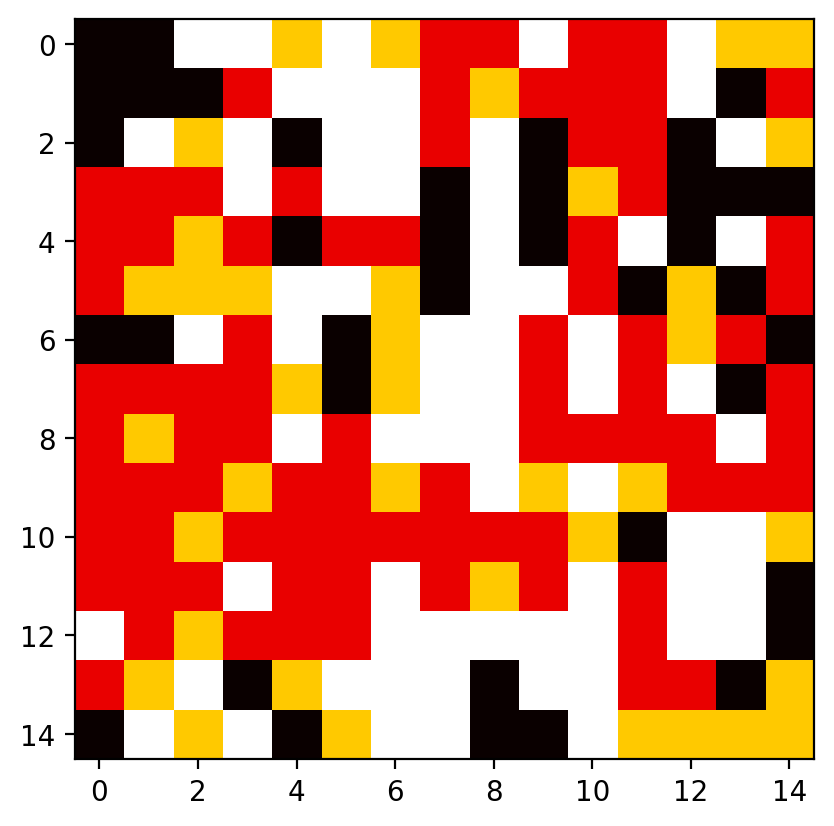

In [ ]:
plt.imshow(Q_directions, cmap='hot', interpolation='nearest')
plt.show()

# No animation for this one